# South African Language Processing Challenge

South Africa is a multicultural society that is characterised by its rich linguistic diversity. Language is an indispensable tool that can be used to deepen democracy and also contribute to the social, cultural, intellectual, economic and political life of the South African society. With such a multilingual population, it is only obvious that our systems and devices also communicate in multi-languages

In this notebook is my prediction that I'll use to compete in a Kaggle competition by training a classification model to predict in which South African language a piece of text is written in.

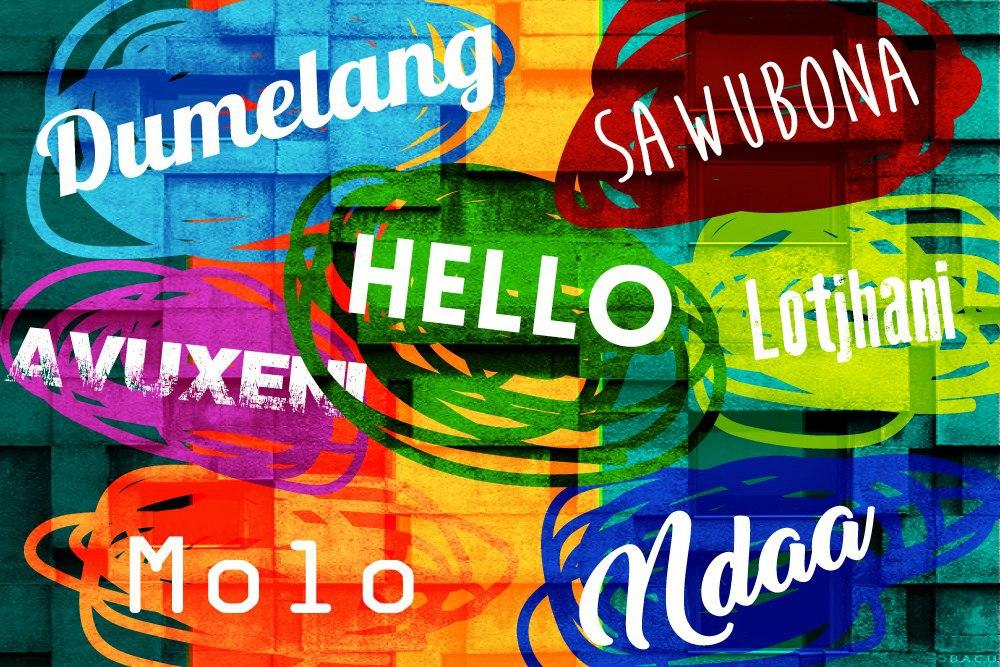

## Data Description

The dataset used for this challenge is the NCHLT Text Corpora collected by the South African Department of Arts and Culture & Centre for Text Technology (CTexT, North-West University, South Africa). The training set was improved through additional cleaning done by Praekelt.

The data is in the form Language ID, Text. The text is in various states of cleanliness. Some NLP techniques will be necessary to clean up the data.

## Language IDs

* afr - Afrikaans
* eng - English
* nbl - isiNdebele
* nso - Sepedi
* sot - Sesotho
* ssw - siSwati
* tsn - Setswana
* tso - Xitsonga
* ven - Tshivenda
* xho - isiXhosa
* zul - isiZulu

## Importing Libraries

In [3]:
import pandas as pd
import numpy as np
import re
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter("ignore")


from sklearn.model_selection import train_test_split

 
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.feature_extraction.text import CountVectorizer   
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer 
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import BernoulliNB,GaussianNB, MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn import preprocessing
from sklearn.preprocessing import OneHotEncoder
from sklearn import metrics
from sklearn.metrics import classification_report, confusion_matrix, f1_score, precision_score, recall_score
import warnings
warnings.filterwarnings("ignore")

## Import Data

In [4]:
train = pd.read_csv("train_set.csv")
test = pd.read_csv("test_Set.csv")

## Exploratory Data Analysis

In [5]:
train.head()

,lang_id,text
0,xho,umgaqo-siseko wenza amalungiselelo kumaziko ax...
1,xho,i-dha iya kuba nobulumko bokubeka umsebenzi na...
2,eng,the province of kwazulu-natal department of tr...
3,nso,o netefatša gore o ba file dilo ka moka tše le...
4,ven,khomishini ya ndinganyiso ya mbeu yo ewa maana...


In [6]:
"""
Looking at info on the data.
Because there are few columns we can also see if there are any missing values if there's a difference in number of texts and lang_id
"""

train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33000 entries, 0 to 32999
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   lang_id  33000 non-null  object
 1   text     33000 non-null  object
dtypes: object(2)
memory usage: 515.8+ KB


Comments: 
* There are no missing values
* The dataset has 33 000 rows and 2 columns

In [7]:
"""
Checking for imbalance in data

"""

train['lang_id'].value_counts()

xho    3000
eng    3000
nso    3000
ven    3000
tsn    3000
nbl    3000
zul    3000
ssw    3000
tso    3000
sot    3000
afr    3000
Name: lang_id, dtype: int64

<AxesSubplot:xlabel='lang_id', ylabel='count'>

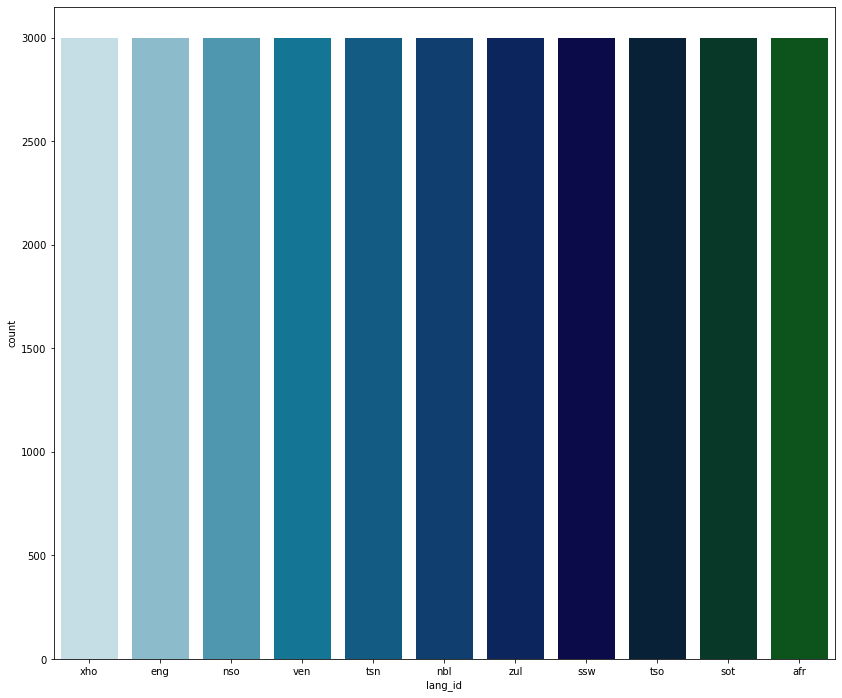

In [186]:
plt.figure(figsize=(14,12))
sns.countplot(x='lang_id', data=train, palette ='ocean_r')

Comments: 
* Dataset is perfectly balanced so we do not have to make use of resampling techniques.
* Next we will preprocess the data

## Preprocessing

In [8]:
"""
Make text lowercase, remove punctuation marks and numbers
"""

def clean_text(message):
    
    message = str(message).lower() #convert to lowercase
    message  = re.sub(r'[!-@#$(),n"%^*?:;~`0-9]', ' ', message) #Remove punctuation

    return message

In [9]:
"""
Creating a copy of train and test datasets
"""

df = train.copy()
test_df = test.copy()

In [10]:
"""
Apply above function on both the test and training set and asssign cleaned data to column tweet:
"""

df['clean_text'] = df['text'].apply(lambda message:clean_text(message))
test_df['clean_text'] = test_df['text'].apply(lambda message:clean_text(message))

In [11]:
"""
Sanity check on train data
"""
df.head()

,lang_id,text,clean_text
0,xho,umgaqo-siseko wenza amalungiselelo kumaziko ax...,umgaqo siseko we za amalu giselelo kumaziko ax...
1,xho,i-dha iya kuba nobulumko bokubeka umsebenzi na...,i dha iya kuba obulumko bokubeka umsebe zi a...
2,eng,the province of kwazulu-natal department of tr...,the provi ce of kwazulu atal departme t of tr...
3,nso,o netefatša gore o ba file dilo ka moka tše le...,o etefatša gore o ba file dilo ka moka tše le...
4,ven,khomishini ya ndinganyiso ya mbeu yo ewa maana...,khomishi i ya di ga yiso ya mbeu yo ewa maa a...


In [10]:
"""
Sanity check on test data
"""

test_df.head()

,index,text,clean_text
0,1,"Mmasepala, fa maemo a a kgethegileng a letlele...",mmasepala fa maemo a a kgethegile g a letlele...
1,2,Uzakwaziswa ngokufaneleko nakungafuneka eminye...,uzakwaziswa gokufa eleko aku gafu eka emi ye...
2,3,Tshivhumbeo tshi fana na ngano dza vhathu.,tshivhumbeo tshi fa a a ga o dza vhathu
3,4,Kube inja nelikati betingevakala kutsi titsini...,kube i ja elikati beti gevakala kutsi titsi i...
4,5,Winste op buitelandse valuta.,wi ste op buitela dse valuta


In [12]:
"""
Encoding our label data. Label encoder encodes categorical data into numeric data so it's easily interpreted by our alorithms
"""
lbl_enc = preprocessing.LabelEncoder()
y = lbl_enc.fit_transform(df.lang_id.values)

In [14]:
"""
We will split our data into our training and validation sets
"""

xtrain, xvalid, ytrain, yvalid = train_test_split(df.clean_text.values, y, stratify=y, random_state=42, test_size=0.1, shuffle=True)

In [15]:
"""
We'll make use of a vectorizer to transform text data into a form the algorithms can interpret.
A CountVectorizer worked out better than a Tfidf-Vectorizer for this problem, so we'll use that
"""

ctv = CountVectorizer()

# Fitting Count Vectorizer to both training and test sets (semi-supervised learning)
ctv.fit(list(xtrain) + list(xvalid))
xtrain_ctv =  ctv.transform(xtrain) 
xvalid_ctv = ctv.transform(xvalid)

## Modelling and Predicting

### Logistic Regression

In [14]:
"""
Creating a logistics regression
""" 

LR = LogisticRegression()
#fit the train data
LR.fit(xtrain_ctv, ytrain)
#predict y labels
y_pred_lr = LR.predict(xvalid_ctv)

In [17]:
"""
Creating a classification report

"""
print(metrics.classification_report(yvalid, y_pred_lr))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       300
           1       1.00      1.00      1.00       300
           2       0.98      0.99      0.99       300
           3       1.00      1.00      1.00       300
           4       0.99      1.00      1.00       300
           5       1.00      0.99      1.00       300
           6       1.00      0.99      1.00       300
           7       1.00      1.00      1.00       300
           8       1.00      1.00      1.00       300
           9       1.00      0.99      0.99       300
          10       0.99      0.99      0.99       300

    accuracy                           1.00      3300
   macro avg       1.00      1.00      1.00      3300
weighted avg       1.00      1.00      1.00      3300



### SVC

In [18]:
"""
Creating SVC
"""

svc = SVC()
#fit the train data
svc.fit(xtrain_ctv, ytrain)
#predict y labels
y_pred_svc = svc.predict(xvalid_ctv)

In [19]:
"""
Creating a classification report

"""
print(metrics.classification_report(yvalid, y_pred_svc))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       300
           1       1.00      1.00      1.00       300
           2       0.98      0.99      0.98       300
           3       1.00      0.99      0.99       300
           4       1.00      0.99      0.99       300
           5       1.00      0.99      1.00       300
           6       0.99      0.99      0.99       300
           7       1.00      1.00      1.00       300
           8       1.00      1.00      1.00       300
           9       0.98      0.98      0.98       300
          10       0.99      0.98      0.98       300

    accuracy                           0.99      3300
   macro avg       0.99      0.99      0.99      3300
weighted avg       0.99      0.99      0.99      3300



## Multinomial NB

In [183]:
"""
Creating Multinomial Naive Bayes
"""

nb = MultinomialNB(alpha =0.52)

#fitting the Naive_Bayes model
nb.fit(xtrain_ctv, ytrain)
#predict y labels
y_pred_nb = nb.predict(xvalid_ctv)



In [184]:

"""
Creating a classification report

"""
print(metrics.classification_report(yvalid, y_pred_nb))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       300
           1       0.99      1.00      1.00       300
           2       1.00      1.00      1.00       300
           3       1.00      1.00      1.00       300
           4       1.00      1.00      1.00       300
           5       1.00      1.00      1.00       300
           6       1.00      1.00      1.00       300
           7       1.00      1.00      1.00       300
           8       1.00      1.00      1.00       300
           9       1.00      1.00      1.00       300
          10       1.00      0.99      1.00       300

    accuracy                           1.00      3300
   macro avg       1.00      1.00      1.00      3300
weighted avg       1.00      1.00      1.00      3300



### BernoulliNB

In [158]:
"""
Creating Bernoulli Naive Bayes model
"""

clf = BernoulliNB(alpha = 0.52)
#fit the train data
clf.fit(xtrain_ctv, ytrain)
#predict y labels
y_pred_clf = nb.predict(xvalid_ctv)

"""
Creating a classification report

"""
print(metrics.classification_report(yvalid, y_pred_clf))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       300
           1       0.99      1.00      1.00       300
           2       1.00      1.00      1.00       300
           3       1.00      1.00      1.00       300
           4       1.00      1.00      1.00       300
           5       1.00      1.00      1.00       300
           6       1.00      1.00      1.00       300
           7       1.00      1.00      1.00       300
           8       1.00      1.00      1.00       300
           9       1.00      1.00      1.00       300
          10       1.00      0.99      1.00       300

    accuracy                           1.00      3300
   macro avg       1.00      1.00      1.00      3300
weighted avg       1.00      1.00      1.00      3300



## Linear SVC

In [22]:
"""
Creating Linear SVC
"""

lsvc = LinearSVC()
#fit the train data
lsvc.fit(xtrain_ctv, ytrain)
#predict y labels
y_pred_lsvc = lsvc.predict(xvalid_ctv)

In [23]:
"""
Creating a classification report

"""
print(metrics.classification_report(yvalid, y_pred_lsvc))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       300
           1       1.00      1.00      1.00       300
           2       0.99      0.99      0.99       300
           3       1.00      1.00      1.00       300
           4       1.00      1.00      1.00       300
           5       1.00      1.00      1.00       300
           6       1.00      1.00      1.00       300
           7       1.00      1.00      1.00       300
           8       1.00      1.00      1.00       300
           9       1.00      0.99      0.99       300
          10       0.99      0.99      0.99       300

    accuracy                           1.00      3300
   macro avg       1.00      1.00      1.00      3300
weighted avg       1.00      1.00      1.00      3300



## Hyperparameter Optimization

In [153]:
"""
-We'll make use of a RandomizedGridSearch to look for the best parameters for our classification model.

-The model we are looking to optimize is the Multinomial Naive Bayes. Its performance turns out to be identical to that of the
Bernoulli Naive Bayes model so we'll optimize just one of them (the MulitnomialNB).

- The only parameter we can optimize for is the value of alpha and upon iterating a few times, the best alpha value lies close to the
0.52 value

"""


%%time


model=MultinomialNB()
param={'alpha': [0, 0.00001, 0.0001, 0.4,0.45,0.48,0.52,0.521,0.5212,0.5213,0.5214,0.5215,0.5216,0.522]}
clf = RandomizedSearchCV(model,param,scoring='f1',cv=20,return_train_score=True)

Wall time: 0 ns


In [154]:
clf.fit(xtrain_ctv, ytrain)

RandomizedSearchCV(cv=20, estimator=MultinomialNB(),
                   param_distributions={'alpha': [0, 1e-05, 0.0001, 0.4, 0.45,
                                                  0.48, 0.52, 0.521, 0.5212,
                                                  0.5213, 0.5214, 0.5215,
                                                  0.5216, 0.522]},
                   return_train_score=True, scoring='f1')

In [155]:
clf.best_params_

{'alpha': 0.52}

## Discussion on Model Performance

* My final submission will be based on a mean F1 score so that is the metric I'm most interested in
* A few models gave a seemingly perfect F1 score but scores varied upon submission
* The Multinomial Naive Bayes gave the best submission score of the lot with a score of .964


## Submission

In [159]:
X_sub = test_df['clean_text']

In [160]:
X_sub_trans = ctv.transform(X_sub)

In [161]:
Sub_pred = nb.predict(X_sub_trans)

In [162]:
Kaggle_sub = test_df[["index"]]

In [163]:
Kaggle_sub["lang_id"]  = lbl_enc.inverse_transform(Sub_pred)

In [164]:
Kaggle_sub.to_csv('Hack_final.csv', index = None)